In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

'''
Bayes: What is the proability a patient will have side effect X (Decreased weight) given medication Y (Xolair) (based on age/gender)
'''

#importing csv files, loading into pandas dataframes

def new_df_from_col(df, list_columns):
    '''
    Returns new dataframe given old df and list of columns from old df
    '''
    new_df = df[list_columns]
    return new_df 

drug_df = pd.read_csv('../drug_fda.csv')
new_drug_df = new_df_from_col(drug_df, ['primaryid', 'caseid', 'drug_seq', 'role_cod', 'drugname',
       'val_vbm', 'cum_dose_chr', 'cum_dose_unit', 'lot_num'])

demo_df = pd.read_csv('../demo_fda.csv')
new_demo_df = new_df_from_col(demo_df,['primaryid', 'caseid', 'caseversion', 'age', 'age_cod',
       'sex', 'wt', 'wt_cod', 'occp_cod', 'reporter_country', 'occr_country',
       'occp_cod_num'])

outcomes_df = pd.read_csv('../outcomes_fda.csv')

reactions_df = pd.read_csv('../reaction_fda.csv')


#merging into 1 merged df
def merge_dfs(df1,df2,on,how='left'):
    '''
    Takes in two dataframes and returns merged dataframe.
    '''
    return df1.merge(df2,on,how)

drug_demo = new_drug_df.merge(new_demo_df, on='primaryid', how='left')
drug_demo_outcomes = drug_demo.merge(outcomes_df,on='primaryid',how='left')
merged_df = drug_demo_outcomes.merge(reactions_df, on='primaryid',how='left')


/Users/endernova/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/endernova/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
def code_to_numeric(code):
    '''
    Converts patient age to age in years
    '''
    if code == 'DY':
        return 1/365
    if code == 'YR':
        return 1
    if code == np.nan:
        return 0
    if code == 'MON':
        return 1/12
    if code == 'DEC':
        return 10
    if code == 'WK':
        return 7/365
    if code == 'HR':
        return 1/8760
        
merged_df['age_multiplier'] = merged_df['age_cod'].map(code_to_numeric)
merged_df['age_in_years'] = merged_df['age'] * merged_df['age_multiplier']

In [52]:
def weight_conversion(code):
    '''
    converts patient weight to weight in lbs
    '''
    if code == 'KG':
        return 2.20462
    if code == np.nan:
        return 0
    if code == 'LBS':
        return 1

merged_df['weight_multiplier'] = merged_df['wt_cod'].map(weight_conversion)
merged_df['wt_in_lbs'] = merged_df['weight_multiplier'] * merged_df['wt']
merged_df['age_group'] = (merged_df['age_in_years'] // 10) * 10 
merged_df['age'].round(0)

#Filtering extreme outliers
merged_df = merged_df[merged_df['wt_in_lbs'] <= 500]
merged_df = merged_df[merged_df['age'] > 0]

np.median(merged_df['wt_in_lbs'])

158.13740000076294

In [38]:
#Creating abbreviated dataframe from merged df with columns of interest for hypothesis testing
abrv_df = merged_df[['age_in_years','sex','age_group','drugname','outc_cod','occp_cod']]

np.mean(abrv_df['age_in_years']) #Avg age 58.077675310317574 --> Going to use Avg age for hypothesis testing
np.median(abrv_df['age_in_years']) #Median 62.0

#creating 2 dfs for hypothesis testing
# below_mean_age = abrv_df[abrv_df['age_in_years'] < 58]
# above_mean_age = abrv_df[abrv_df['age_in_years'] >= 58]

abrv_df['age_in_years'] = abrv_df['age_in_years'].round(0)

/Users/endernova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [39]:
import scipy.stats as stats

'''
CODE MEANING_TEXT
 ---- ------------
 DE Death
 LT Life-Threatening
 HO Hospitalization - Initial or Prolonged
 DS Disability
 CA Congenital Anomaly
 RI Required Intervention to Prevent Permanent Impairment/Damage
 OT Other Serious (Important Medical Event)
 
'''
'''
Hypothesis Test 1: 
H0: There is no difference in proportion of deaths related to adverse drug events among men and women.
Ha: There is a difference in proportion of deaths related to adverse drug events between men and women. 
'''

#we are getting boolean values for the presence or absence of catgegorical data
outcome_codes = pd.get_dummies(abrv_df['outc_cod'])
mask = abrv_df['sex'] == 'M'
mask2 = abrv_df['sex'] == 'F'

male = outcome_codes[mask]
female = outcome_codes[mask2]

grouped_summed_male = male.groupby(abrv_df['age_group']).aggregate(sum)
grouped_summed_female = female.groupby(abrv_df['age_group']).aggregate(sum)

grouped_summed_male['Deaths_Male'] = grouped_summed_male['DE']
grouped_summed_female['Deaths_Female'] = grouped_summed_female['DE']

contingency_table = pd.concat([grouped_summed_male['Deaths_Male'], grouped_summed_female['Deaths_Female']], axis=1).dropna().reset_index()

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# proportion = np.sum(below_age['DE'])/below_age['DE'].shape[0]

stats.chi2_contingency(contingency_table)

(52348.04823756897,
 0.0,
 20,
 array([[3.98016712e+00, 1.15133209e+03, 1.10768775e+03],
        [6.48997643e+00, 1.87733778e+03, 1.80617224e+03],
        [8.60229667e+00, 2.48836290e+03, 2.39403481e+03],
        [3.43775283e+01, 9.94429385e+03, 9.56732862e+03],
        [5.06341278e+01, 1.46467960e+04, 1.40915698e+04],
        [8.85978517e+01, 2.56284589e+04, 2.46569432e+04],
        [1.47419199e+02, 4.26435497e+04, 4.10270311e+04],
        [1.43475967e+02, 4.15029016e+04, 3.99296224e+04],
        [5.99223569e+01, 1.73335768e+04, 1.66765009e+04],
        [6.26309108e+00, 1.81170727e+03, 1.74302963e+03],
        [2.37438162e-01, 6.86830896e+01, 6.60794722e+01]]))

In [84]:
def chisquare_test(outcome_code):
    
    outcome_codes = pd.get_dummies(abrv_df['outc_cod'])
    mask = abrv_df['sex'] == 'M'
    mask2 = abrv_df['sex'] == 'F'

    male = outcome_codes[mask]
    female = outcome_codes[mask2]

    grouped_summed_male = male.groupby(abrv_df['age_group']).aggregate(sum)
    grouped_summed_female = female.groupby(abrv_df['age_group']).aggregate(sum)

    grouped_summed_male['Deaths_Male'] = grouped_summed_male[outcome_code]
    grouped_summed_female['Deaths_Female'] = grouped_summed_female[outcome_code]
    
    contingency_table = pd.concat([grouped_summed_male['Deaths_Male'], grouped_summed_female['Deaths_Female']], axis=1).dropna().reset_index()

    return contingency_table

#     chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
#     stats.chi2_contingency(contingency_table)

chisquare_test('LT')


,age_group,Deaths_Male,Deaths_Female
0,0.0,3334.0,5768.0
1,10.0,2614.0,5755.0
2,20.0,2394.0,7288.0
3,30.0,13348.0,7878.0
4,40.0,7559.0,13474.0
5,50.0,17997.0,21741.0
6,60.0,30208.0,38000.0
7,70.0,22206.0,29147.0
8,80.0,9682.0,10048.0
9,90.0,121.0,793.0


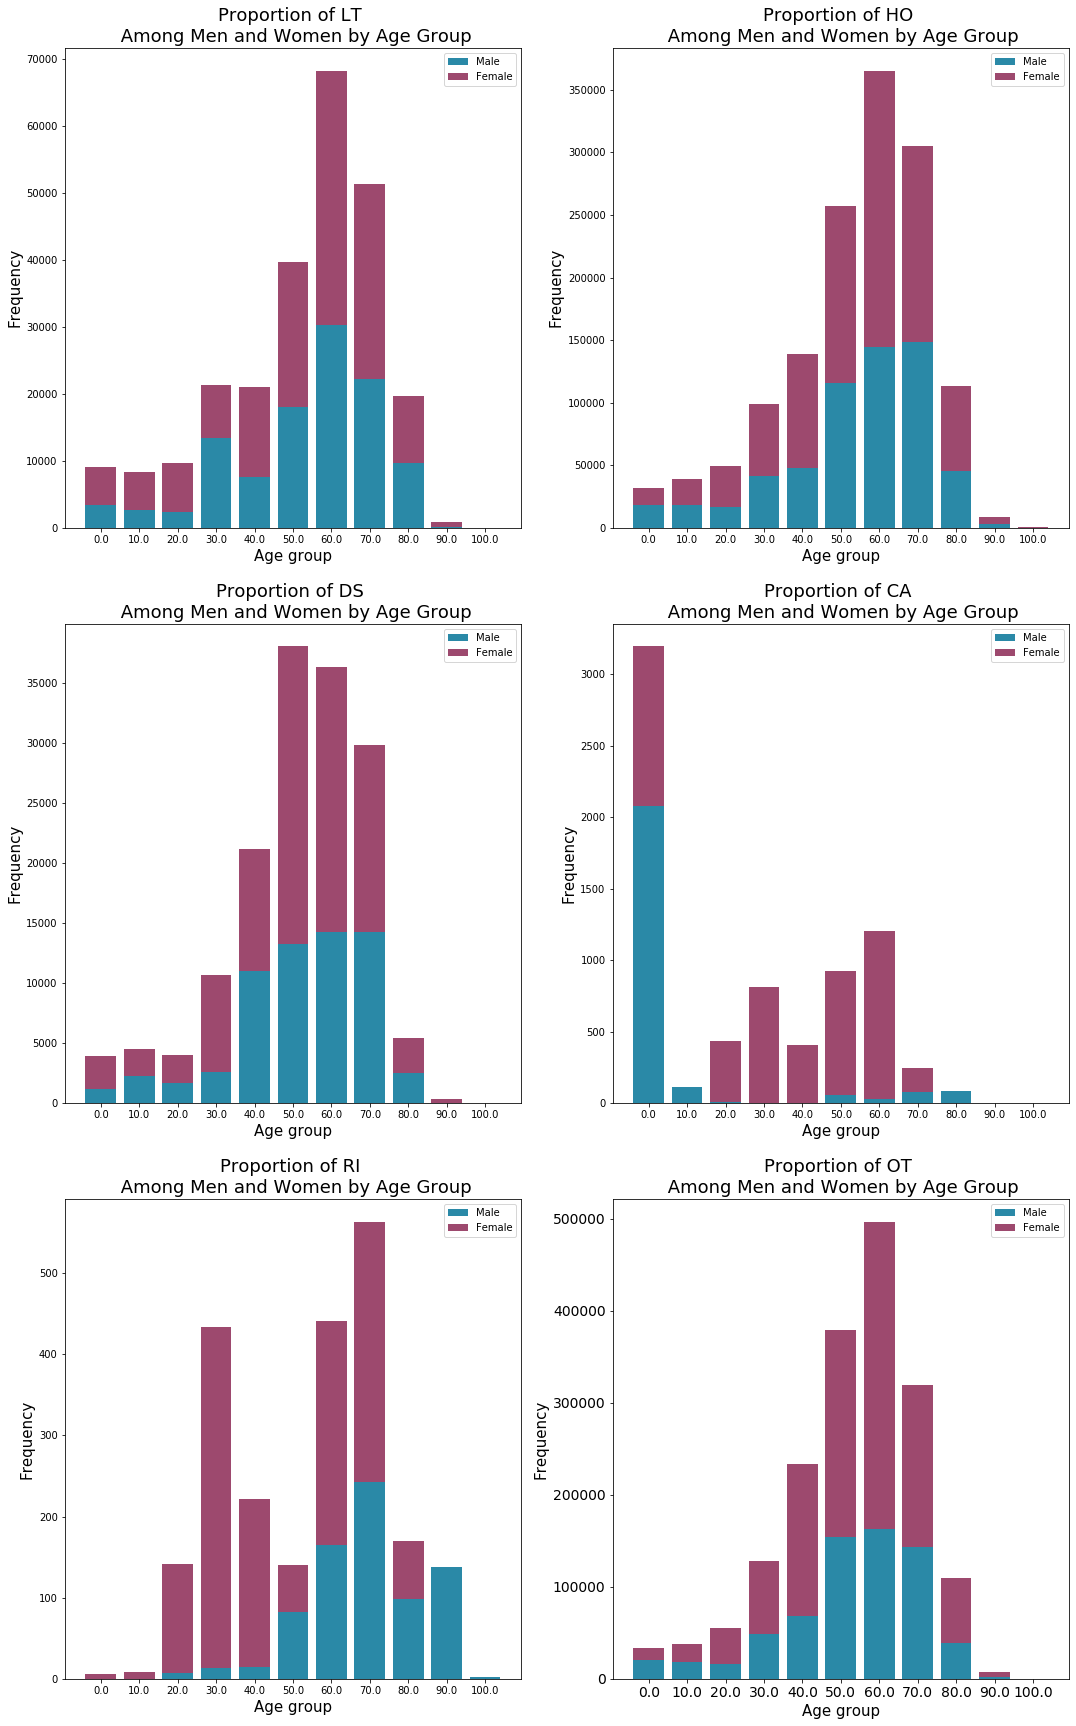

In [102]:
fig, axs = plt.subplots(3, 2, figsize=(18,30))
outcome_codes = ['LT','HO', 'DS', 'CA', 'RI', 'OT']

for ax, code in zip(axs.flatten(), outcome_codes):
    contingency_table = chisquare_test(code)
    m_deaths = contingency_table['Deaths_Male']
    f_deaths = contingency_table['Deaths_Female']
    categories = contingency_table['age_group'].apply(str)
    ax.bar(categories, m_deaths, color='#2A89A7')
    ax.bar(categories, f_deaths, bottom=m_deaths ,color='#9D496E')
    ax.legend(('Male', 'Female'))
    ax.set_xlabel('Age group', fontsize = 15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_title(f'Proportion of {code} \n Among Men and Women by Age Group', fontsize=18)
    ax.set_ylabel('Frequency', fontsize=15)
    plt.savefig('proportions_outcomes.png')

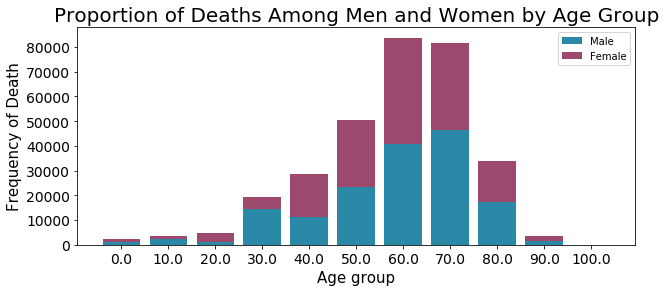

In [40]:
fig, ax = plt.subplots(1,figsize=(10,4))

m_deaths = contingency_table['Deaths_Male']
f_deaths = contingency_table['Deaths_Female']
categories = contingency_table['age_group'].apply(str)
ax.bar(categories, m_deaths, color='#2A89A7')
ax.bar(categories, f_deaths, bottom=m_deaths ,color='#9D496E')
ax.legend(('Male', 'Female'))
ax.set_xlabel('Age group', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_title('Proportion of Deaths Among Men and Women by Age Group', fontsize=20)
ax.set_ylabel('Frequency of Death', fontsize=15)
plt.savefig('proportion_deaths.png');


In [42]:
# x = merged_df.groupby(['age_group','sex'])

x = merged_df.groupby(['drugname']).count()['pt']
x.idxmax(axis=0, skipna = True)


'XOLAIR'

In [43]:
rslt_df = merged_df[merged_df['drugname'] == 'XOLAIR']
top_adverse_event = rslt_df.groupby('pt').count()
top_ADE = top_adverse_event[top_adverse_event['primaryid'] == top_adverse_event['primaryid'].max()]
top_ADE

,primaryid,caseid_x,drug_seq,role_cod,drugname,val_vbm,cum_dose_chr,cum_dose_unit,lot_num,caseid_y,...,occp_cod_num,caseid_x,outc_cod,caseid_y,drug_rec_act,age_multiplier,age_in_years,weight_multiplier,wt_in_lbs,age_group
pt,,,,,,,,,,,,,,,,,,,,,
Weight decreased,2579,2579,2579,2579,2579,2579,0,0,2406,2579,...,2579,2579,2579,2579,0,2579,2579,2579,2579,2579


In [44]:
rslt_df = merged_df[merged_df['drugname'] == 'NUCALA']
top_adverse_event = rslt_df.groupby('pt').count().sort_values(by='primaryid',ascending=False)
top_adverse_event.head()


,primaryid,caseid_x,drug_seq,role_cod,drugname,val_vbm,cum_dose_chr,cum_dose_unit,lot_num,caseid_y,...,occp_cod_num,caseid_x,outc_cod,caseid_y,drug_rec_act,age_multiplier,age_in_years,weight_multiplier,wt_in_lbs,age_group
pt,,,,,,,,,,,,,,,,,,,,,
Dyspnoea,20,20,20,20,20,20,0,0,15,20,...,20,19,19,20,0,20,20,20,20,20
Asthma,13,13,13,13,13,13,0,0,8,13,...,13,13,13,13,0,13,13,13,13,13
Headache,11,11,11,11,11,11,0,0,8,11,...,11,10,10,11,0,11,11,11,11,11
Cough,10,10,10,10,10,10,0,0,6,10,...,10,9,9,10,0,10,10,10,10,10
Urticaria,9,9,9,9,9,9,0,0,9,9,...,9,7,7,9,0,9,9,9,9,9


In [46]:
rslt_df = merged_df[merged_df['drugname'] == 'XOLAIR']
top_adverse_event = rslt_df.groupby('pt').count().sort_values(by='primaryid',ascending=False)
top_adverse_event.head()

,primaryid,caseid_x,drug_seq,role_cod,drugname,val_vbm,cum_dose_chr,cum_dose_unit,lot_num,caseid_y,...,occp_cod_num,caseid_x,outc_cod,caseid_y,drug_rec_act,age_multiplier,age_in_years,weight_multiplier,wt_in_lbs,age_group
pt,,,,,,,,,,,,,,,,,,,,,
Weight decreased,2579,2579,2579,2579,2579,2579,0,0,2406,2579,...,2579,2579,2579,2579,0,2579,2579,2579,2579,2579
Dyspnoea,2348,2348,2348,2348,2348,2348,0,0,2101,2348,...,2348,2348,2348,2348,0,2348,2348,2348,2348,2348
Asthma,2333,2333,2333,2333,2333,2333,0,0,2090,2333,...,2332,2333,2333,2333,0,2333,2333,2333,2333,2333
Nasopharyngitis,2312,2312,2312,2312,2312,2312,4,4,2116,2312,...,2312,2312,2312,2312,0,2312,2312,2312,2312,2312
Cough,2160,2160,2160,2160,2160,2160,0,0,1957,2160,...,2160,2160,2160,2160,0,2160,2160,2160,2160,2160


In [50]:
#Bayesian: given age, gender, medication --> side effect
#P(side effect | age,gender) = p(age, gender | side effect) * P(side effect) / P(age,gender)
(merged_df['pt'] == 'Weight decreased').sum() #26948 people have SE
((merged_df['age_group'] == 60) & (merged_df['sex'] == 'M') & (merged_df['pt'] == 'Weight decreased')).sum() #2358 
#P(60,M) = 2358/26948 = 0.0875
#P(side effect) = 
#P(age,gender | side effect) = 

2358